In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
from sklearn.naive_bayes import GaussianNB

In [3]:
from embed.gin_evaluation import GINMetric,load_feature_extractor

Using backend: pytorch


In [5]:

import torch
import dgl
import networkx as nx

grids_nx = []
for i in range(10, 20):
    for j in range(10, 20):
        grids_nx.append(nx.grid_2d_graph(i, j))
# grids_nx = [nx.grid_2d_graph(3,3) for _ in range(5)]
# lobsters = gen.make_lobster_graphs()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
grids = [dgl.DGLGraph(g).to(device) for g in grids_nx] # Convert graphs to DGL from NetworkX

C:\Users\Lion\anaconda3\envs\gnn\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [6]:
gin = load_feature_extractor(device=device)
mmd_eval = GINMetric(gin)
embeds = mmd_eval.get_embed(grids)


orthogonal


In [7]:
max_node=400

In [8]:
grids_nx = []
for i in range(10, 20):
    for j in range(10, 20):
        t = np.zeros((max_node,max_node))
        t[:i*j,:j*i]=nx.adjacency_matrix(nx.grid_2d_graph(i, j)).todense()
        grids_nx.append(t.astype('float32'))



In [9]:
train = grids_nx[:80]
test = grids_nx[80:]

In [66]:
grids_nx[2].shape

(400, 400)

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(70, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, max_node*max_node),
      nn.Sigmoid()
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  
if __name__ == '__main__':
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare CIFAR-10 dataset
  # dataset = [(embeds[i] , np.array(nx.adjacency_matrix(g).todense()).reshape(81).astype('float32')) for i,g in enumerate(grids_nx)]
  dataset = [(np.random.normal(size=(70)).astype('float32') , g.reshape(max_node*max_node).astype('float32')) for i,g in enumerate(grids_nx)]

  trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
  
  # Initialize the MLP
  mlp = MLP()
  mlp.to(device)
  # Define the loss function and optimizer
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
  # Run the training loop
  for epoch in range(0, 5000): # 5 epochs at maximum
    if(epoch%10==0):
      print(f'Starting epoch {epoch+1}')
    
    current_loss = 0.0
    for i, data in enumerate(trainloader, 0): 
      inputs, targets = data
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = mlp(inputs)
      loss = loss_function(outputs, targets) 
      loss.backward()
      optimizer.step()
      current_loss += loss.item()

    if epoch%10==0:
      print(f"loss:{current_loss}")
    current_loss = 0.0

  print('Training process has finished.')

Starting epoch 1
loss:2.4935403764247894
Starting epoch 11
loss:1.7849696278572083
Starting epoch 21
loss:0.4904663972556591
Starting epoch 31
loss:0.13346195593476295
Starting epoch 41
loss:0.06808329001069069
Starting epoch 51
loss:0.04837436624802649
Starting epoch 61
loss:0.040095074800774455
Starting epoch 71
loss:0.03583871526643634
Starting epoch 81
loss:0.033392576267942786
Starting epoch 91
loss:0.031821774085983634
Starting epoch 101
loss:0.03075573965907097
Starting epoch 111
loss:0.030004992615431547
Starting epoch 121
loss:0.029440393904224038
Starting epoch 131
loss:0.028998288558796048
Starting epoch 141
loss:0.028650060296058655
Starting epoch 151
loss:0.028365241596475244
Starting epoch 161
loss:0.028125298907980323
Starting epoch 171
loss:0.02792442962527275
Starting epoch 181
loss:0.02775089256465435
Starting epoch 191
loss:0.02759584318846464
Starting epoch 201
loss:0.027446314925327897
Starting epoch 211
loss:0.02732222410850227
Starting epoch 221
loss:0.0271975568

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [122]:
data.to(device).is_cuda

AttributeError: 'list' object has no attribute 'to'

In [31]:
current_loss

0.2037995457649231

232


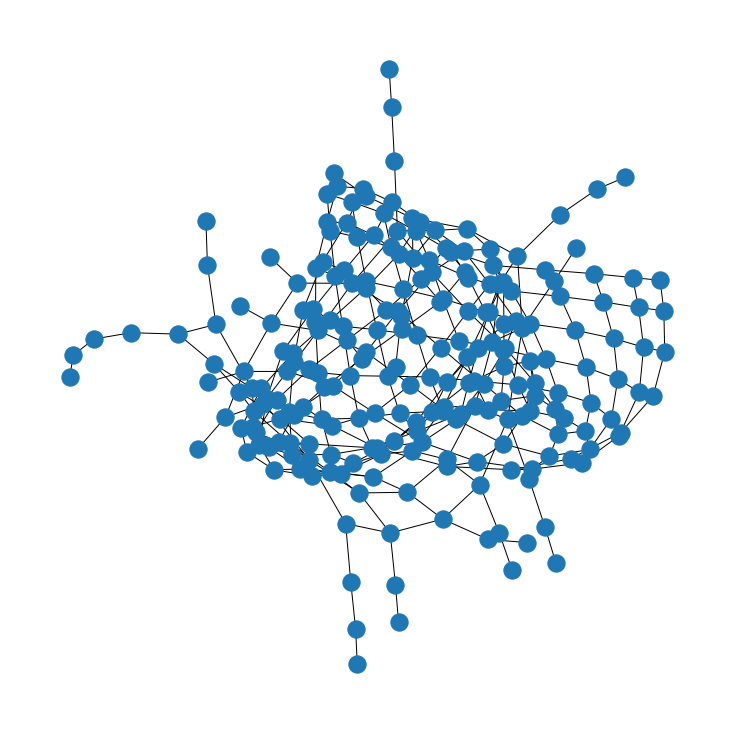

228


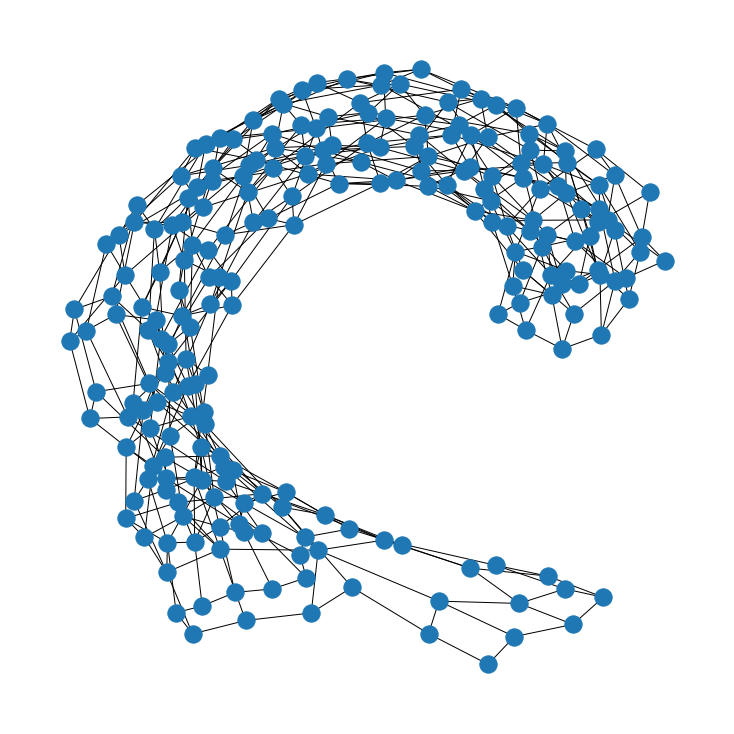

255


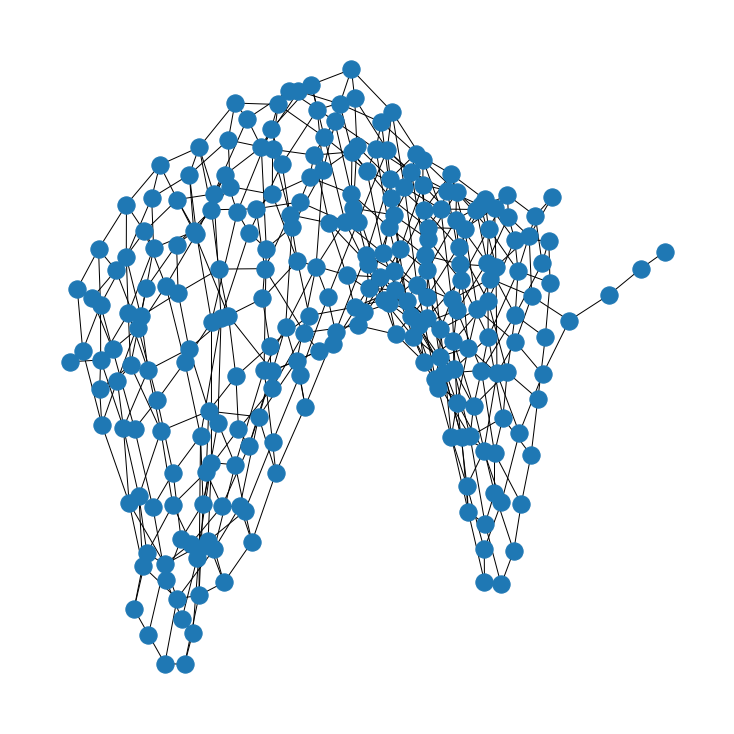

204


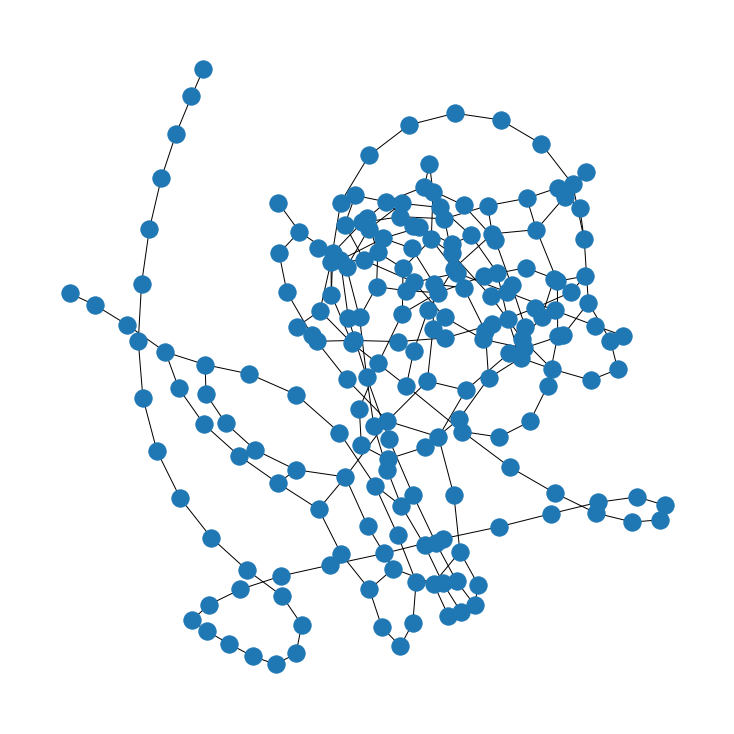

272


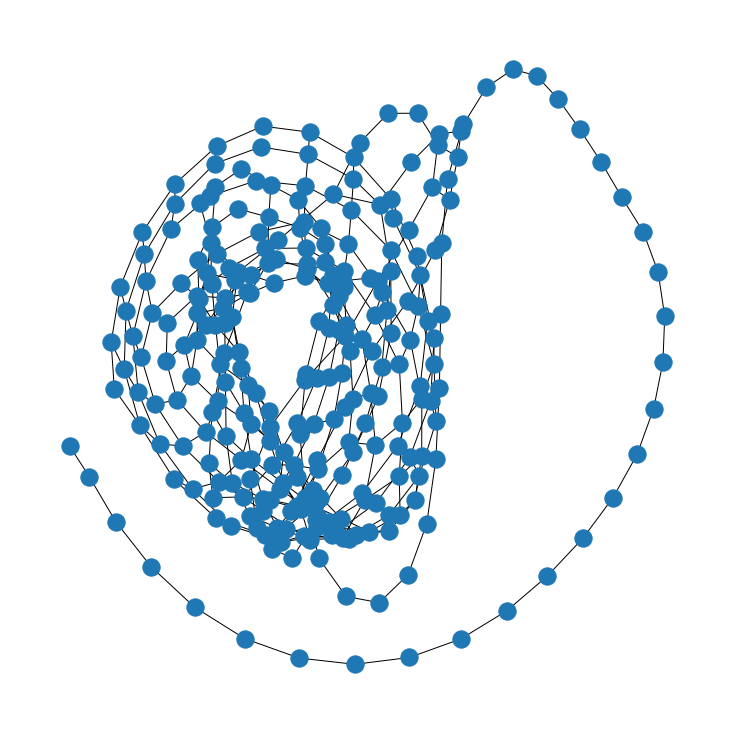

In [13]:
mlp.to('cpu')
for i in range(5):
    pred = mlp(torch.from_numpy(np.random.normal(size=70).astype('float32')))
    preds = np.array(pred.detach().cpu())
    G=nx.Graph((preds>0.3).astype('int').reshape(max_node,max_node))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    print(len(G0.nodes))
    plt.figure(figsize=(10,10))
    nx.draw(G0)
    plt.show()

In [126]:
mlp=mlp.to(device)

In [130]:
mmp = MLP()
mmp.load_state_dict(torch.load('mlp.mld'))

<All keys matched successfully>

In [131]:
mmp.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=160000, bias=True)
    (5): Sigmoid()
  )
)

In [136]:
inputs.is_cuda,targets.is_cuda,outputs.is_cuda,loss.is_cuda

(True, True, True, True)

In [139]:
optimizer = torch.optim.Adam(mmp.parameters(), lr=1e-4)
for epoch in range(0, 200): # 5 epochs at maximum
    if(epoch%10==0):
      print(f'Starting epoch {epoch+1}')
    
    current_loss = 0.0
    for i, data in enumerate(trainloader, 0): 
      inputs, targets = data
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = mmp(inputs)
      loss = loss_function(outputs, targets) 
      loss.backward()
      optimizer.step()
      current_loss += loss.item()

    if epoch%10==0:
      print(f"loss:{current_loss}")
    current_loss = 0.0

print('Training process has finished.')

Starting epoch 1
loss:0.0007089562332112109
Starting epoch 11
loss:0.0006775749898224603
Starting epoch 21
loss:0.0006548689807459596
Starting epoch 31
loss:0.0006355459208862158
Starting epoch 41
loss:0.0006188226734593627
Starting epoch 51
loss:0.0006042697123120888
Starting epoch 61
loss:0.000591535462262982
Starting epoch 71
loss:0.0005802372979815118
Starting epoch 81
loss:0.0005703321075998247
Starting epoch 91
loss:0.0005613764997178805
Starting epoch 101
loss:0.0005533855760404549
Starting epoch 111
loss:0.0005461711161842686
Starting epoch 121
loss:0.0005396066221692308
Starting epoch 131
loss:0.0005337825655260531
Starting epoch 141
loss:0.0005284513349579356
Starting epoch 151
loss:0.000523803879332263
Starting epoch 161
loss:0.0005196224831252039
Starting epoch 171
loss:0.000515849318162509
Starting epoch 181
loss:0.0005124727094880654
Starting epoch 191
loss:0.0005095014187190827
Training process has finished.


In [11]:
torch.save(mlp.state_dict(), 'mlp5000.mld')


In [40]:
from tensorflow import keras


In [41]:
model = keras.models.load_model('kerasModel/unet600e.mdl')


In [42]:
graphs_test = []
for i in range(18, 20):
    for j in range(10, 20):
        graphs_test.append(nx.grid_2d_graph(i, j))

In [20]:
from utils.dist_helper import compute_mmd, gaussian_emd, gaussian, emd, gaussian_tv
from utils.eval_helper import *

In [21]:
def evaluate(graph_gt, graph_pred, degree_only=True):
    mmd_degree = degree_stats(graph_gt, graph_pred)

    if degree_only:
        mmd_4orbits = 0.0
        mmd_clustering = 0.0
        mmd_spectral = 0.0
    else:
        mmd_4orbits = orbit_stats_all(graph_gt, graph_pred)
        mmd_clustering = clustering_stats(graph_gt, graph_pred)
        mmd_spectral = spectral_stats(graph_gt, graph_pred)

    return mmd_degree, mmd_clustering, mmd_4orbits, mmd_spectral


In [100]:
len(graphs_test)

20

In [46]:
graphs_gen = []
for i in range(20):
    pred = model.predict(np.array([np.random.normal(size=(400,400,3)).astype("float16")]))
    preds = pred[0,:,:,2]
    G=nx.Graph((preds>0.25).astype('int'))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    graphs_gen.append(G0)

In [47]:
num_nodes_test = [len(gg.nodes) for gg in graphs_test]  # shape B X 1
num_nodes_gen = [len(aa) for aa in graphs_gen]

(
    mmd_degree_test,
    mmd_clustering_test,
    mmd_4orbits_test,
    mmd_spectral_test,
) = evaluate(graphs_test, graphs_gen, degree_only=False)
mmd_num_nodes_test = compute_mmd(
    [np.bincount(num_nodes_test)],
    [np.bincount(num_nodes_gen)],
    kernel=gaussian_emd,
)

In [48]:
print(
"Test MMD scores of #nodes/degree/clustering/4orbits/spectral are = {}/{}/{}/{}/{}".format(
    mmd_num_nodes_test,
    mmd_degree_test,
    mmd_clustering_test,
    mmd_4orbits_test,
    mmd_spectral_test,
)
)

Test MMD scores of #nodes/degree/clustering/4orbits/spectral are = 2.0/0.6165496360876142/0.04942907885884673/0.9542939260931904/0.1677170100376082
